## This file was used for data analysis of breast data and subsetting to protein coding genes

In [63]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from pybiomart import Server
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
# Define the main folder containing all sample subfolders
input_file = "Datasets/DESeq2Input/breastCounts.csv"
sample_sheet = pd.read_csv("Datasets/DESeq2Input/breast_sample_sheet.tsv", sep='\t')
clinical = pd.read_csv("Datasets/DESeq2Input/breast_clinical.tsv", sep='\t', low_memory=False)
metadata_file = "Datasets/DESeq2Input/breastMetadata.csv"

In [3]:
df = pd.read_csv(input_file)

In [4]:
df.index = df['gene_id']
df = df.drop('gene_id', axis =1)

In [5]:
df

2c3000b7-4db9-4f00-a82a-ca6802806631  \
gene_id                                                    
ENSG00000000003.15                                2304.0   
ENSG00000000005.6                                    7.0   
ENSG00000000419.13                                4979.0   
ENSG00000000457.14                                1544.0   
ENSG00000000460.17                                1723.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  256.0   
ENSG00000288674.1                                    7.0   
ENSG00000288675.1                                   15.0   

                    519b92e0-0dbc-471c-988f-48ce9dc95be3  \
gene_id                                                    
ENSG00000000003.15                                1033.0   
ENSG00000000005.6                                    4.0   
ENSG00000000419.13                                2240.0   
ENSG00000000457.14                                1702.0   
ENSG00000000460.17                                 587.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  458.0   
ENSG00000288674.1                                    2.0   
ENSG00000288675.1                                   10.0   

                    f2bf29d2-4c33-4810-90e8-88f37ea47bc8  \
gene_id                                                    
ENSG00000000003.15                                2967.0   
ENSG00000000005.6                                   17.0   
ENSG00000000419.13                                5568.0   
ENSG00000000457.14                                3458.0   
ENSG00000000460.17                                2060.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                 1024.0   
ENSG00000288674.1                                    6.0   
ENSG00000288675.1                                   46.0   

                    59858555-bc6a-4286-8280-0f8341123cac  \
gene_id                                                    
ENSG00000000003.15                                9201.0   
ENSG00000000005.6                                    9.0   
ENSG00000000419.13                                4186.0   
ENSG00000000457.14                                2054.0   
ENSG00000000460.17                                4333.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  741.0   
ENSG00000288674.1                                   11.0   
ENSG00000288675.1                                  105.0   

                    de6f1503-33d7-4f86-b835-bdffba7ea4e3  \
gene_id                                                    
ENSG00000000003.15                                1162.0   
ENSG00000000005.6                                   90.0   
ENSG00000000419.13                                1703.0   
ENSG00000000457.14                                1401.0   
ENSG00000000460.17                                 876.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  197.0   
ENSG00000288674.1                                    8.0   
ENSG00000288675.1                                   14.0   

                    f0a63361-78bb-4a7f-9d78-31f7b2980ba2  \
gene_id                                                

## Unique Genes

In [7]:
gene_ids = df.index.to_series()

# Remove version suffix (e.g., .15)
gene_ids_stripped = gene_ids.str.replace(r'\.\d+$', '', regex=True)

# Get number of unique genes
num_unique_genes = gene_ids_stripped.nunique()

print(f"Number of unique gene IDs (version-stripped): {num_unique_genes}")

Number of unique gene IDs (version-stripped): 58048


## Get protein coding genes

In [8]:
# Connect to Ensembl
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Query gene info (without version)
gene_ids_stripped = pd.Series(gene_ids).str.replace(r'\.\d+$', '', regex=True)

# Get gene type info for your IDs
annotations = dataset.query(attributes=['ensembl_gene_id', 'gene_biotype'])
protein_coding_genes = annotations[annotations['Gene type'] == 'protein_coding']['Gene stable ID']

In [9]:
df_filtered =  df[df.index.str.replace(r'\.\d+$', '', regex=True).isin(protein_coding_genes)]

In [10]:
df_filtered.shape

(19529, 1231)

In [11]:
output_file = "DESeq2Local/DESeq2Input/breastFilteredGenesCounts.csv"
df_filtered.to_csv(output_file)

## Visualize Clinical data: UMAP

In [12]:
# Build sample-to-case map
sample_to_case = sample_sheet[['File ID', 'Case ID']].dropna()

In [13]:
len(sample_to_case)

1231

In [14]:
sample_to_case

File ID       Case ID
0     e6cbdcab-7fd1-43a6-be43-68b6a0fb4fe9  TCGA-A2-A25D
1     9415696a-44d9-477f-aba3-0a30ded48778  TCGA-BH-A201
2     ec67e25e-9cc6-45a7-a7c0-8dc778ae14c1  TCGA-AC-A23C
3     61f32a8d-4649-4ea8-8374-00ab281464bf  TCGA-AR-A5QP
4     09a491b5-1bfb-47d9-963f-69f6c7e6c1e5  TCGA-C8-A12P
...                                    ...           ...
1226  236805b9-ea89-43b4-ba51-c09276778e90  TCGA-LL-A5YP
1227  79f97f73-b650-49cf-8654-53038a6c0de7  TCGA-AO-A03L
1228  2455f280-a23c-48ec-b4c1-698b56f72a45  TCGA-BH-A42T
1229  94468afc-faea-4091-af0f-d2df8aec37da  TCGA-A2-A04W
1230  f0107961-a5e1-46ec-b232-a47f0049bc5f  TCGA-AR-A24O

[1231 rows x 2 columns]

In [15]:
# Ensure samples match those in df
sample_to_case = sample_to_case[sample_to_case['File ID'].isin(df.columns)]

In [16]:
len(sample_to_case)

1231

In [17]:
clinical_unique = clinical.drop_duplicates(subset='cases.submitter_id')

In [18]:
len(clinical)

5529

In [19]:
len(clinical_unique)

1095

In [20]:
clinical_columns_to_keep = [
    'cases.submitter_id',
    'cases.disease_type',
    'demographic.gender',
    'demographic.age_at_index',
    'demographic.race',
    # 'demographic.vital_status',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
    #'diagnoses.tissue_or_organ_of_origin',
    #'treatments.initial_disease_status',
    #'treatments.therapeutic_agents',
    #'treatments.treatment_type',
    # 'diagnoses.ajcc_pathologic_n',
    #'diagnoses.ajcc_pathologic_t',
    #'diagnoses.ajcc_pathologic_m'
]

In [21]:
clinical_subset = clinical_unique[clinical_columns_to_keep]

In [22]:
sample_clinical = pd.merge(sample_to_case, clinical_subset,
                           left_on='Case ID',
                           right_on='cases.submitter_id',
                           how='left')

In [23]:
sample_clinical.index = sample_clinical['File ID']
sample_clinical = sample_clinical.drop('File ID', axis =1)

In [24]:
# reorder to match OG order
sample_clinical = sample_clinical.loc[df_filtered.columns.intersection(sample_clinical.index)]

In [25]:
sample_clinical

Case ID cases.submitter_id  \
2c3000b7-4db9-4f00-a82a-ca6802806631  TCGA-C8-A1HM       TCGA-C8-A1HM   
519b92e0-0dbc-471c-988f-48ce9dc95be3  TCGA-A8-A08S       TCGA-A8-A08S   
f2bf29d2-4c33-4810-90e8-88f37ea47bc8  TCGA-AR-A24H       TCGA-AR-A24H   
59858555-bc6a-4286-8280-0f8341123cac  TCGA-AR-A1AH       TCGA-AR-A1AH   
de6f1503-33d7-4f86-b835-bdffba7ea4e3  TCGA-BH-A0BC       TCGA-BH-A0BC   
...                                            ...                ...   
5e789924-9d98-4765-a348-90a27349d906  TCGA-GI-A2C9       TCGA-GI-A2C9   
8a84b9a5-d453-416b-b481-f15402c2eb54  TCGA-BH-A1EU       TCGA-BH-A1EU   
ccb87d7a-2729-4017-bc17-10e5a67bd5cc  TCGA-E2-A15M       TCGA-E2-A15M   
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf  TCGA-BH-A18V       TCGA-BH-A18V   
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac  TCGA-BH-A1EV       TCGA-BH-A1EV   

                                                cases.disease_type  \
2c3000b7-4db9-4f00-a82a-ca6802806631  Ductal and Lobular Neoplasms   
519b92e0-0dbc-471c-988f-48ce9dc95be3  Ductal and Lobular Neoplasms   
f2bf29d2-4c33-4810-90e8-88f37ea47bc8  Ductal and Lobular Neoplasms   
59858555-bc6a-4286-8280-0f8341123cac  Ductal and Lobular Neoplasms   
de6f1503-33d7-4f86-b835-bdffba7ea4e3  Ductal and Lobular Neoplasms   
...                                                            ...   
5e789924-9d98-4765-a348-90a27349d906  Ductal and Lobular Neoplasms   
8a84b9a5-d453-416b-b481-f15402c2eb54  Ductal and Lobular Neoplasms   
ccb87d7a-2729-4017-bc17-10e5a67bd5cc  Ductal and Lobular Neoplasms   
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf  Ductal and Lobular Neoplasms   
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac  Ductal and Lobular Neoplasms   

                                     demographic.gender  \
2c3000b7-4db9-4f00-a82a-ca6802806631             female   
519b92e0-0dbc-471c-988f-48ce9dc95be3             female   
f2bf29d2-4c33-4810-90e8-88f37ea47bc8             female   
59858555-bc6a-4286-8280-0f8341123cac             female   
de6f1503-33d7-4f86-b835-bdffba7ea4e3             female   
...                                                 ...   
5e789924-9d98-4765-a348-90a27349d906             female   
8a84b9a5-d453-416b-b481-f15402c2eb54             female   
ccb87d7a-2729-4017-bc17-10e5a67bd5cc             female   
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf             female   
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac             female   

                                     demographic.age_at_index  \
2c3000b7-4db9-4f00-a82a-ca6802806631                       74   
519b92e0-0dbc-471c-988f-48ce9dc95be3                       71   
f2bf29d2-4c33-4810-90e8-88f37ea47bc8                       65   
59858555-bc6a-4286-8280-0f8341123cac                       51   
de6f1503-33d7-4f86-b835-bdffba7ea4e3                       60   
...                                                       ...   
5e789924-9d98-4765-a348-90a27349d906                       58   
8a84b9a5-d453-416b-b481-f15402c2eb54                       83   
ccb87d7a-2729-4017-bc17-10e5a67bd5cc                       66   
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf                       48   
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac                       45   

                                               demographic.race  \
2c3000b7-4db9-4f00-a82a-ca6802806631                      asian   
519b92e0-0dbc-471c-988f-48ce9dc95be3               not reported   
f2bf29d2-4c33-4810-90e8-88f37ea47bc8                      white   
59858555-bc6a-4286-8280-0f8341123cac                      white   
de6f1503-33d7-4f86-b835-bdffba7ea4e3                      white   
...                                                         ...   
5e789924-9d98-4765-a348-90a27349d906  black or african american   
8a84b9a5-d453-416b-b481-f15402c2eb54                      white   
ccb87d7a-2729-4017-bc17-10e5a67bd5cc                      white   
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf                      white   
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac                      white   

                              

In [26]:
sample_clinical_file = "Datasets/DESeq2Input/breastSampleToClinicalFeatures.csv"
sample_clinical.to_csv(sample_clinical_file)

In [27]:
clinical_disease_columns = [
    # 'demographic.vital_status',
    'cases.disease_type',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
    #'diagnoses.tissue_or_organ_of_origin',
    #'treatments.initial_disease_status',
    #'treatments.therapeutic_agents',
    #'treatments.treatment_type',
    # 'diagnoses.ajcc_pathologic_n',
    #'diagnoses.ajcc_pathologic_t',
    #'diagnoses.ajcc_pathologic_m'
]

In [28]:
metadata_df = pd.read_csv(metadata_file)

In [29]:
normal_samples = metadata_df.loc[metadata_df['condition'] == "normal", 'sample_id']
normal_samples

1118    c9230a1c-9844-43ef-a2c3-95ea6061000b
1119    699e47b8-5396-43eb-927d-8d05b0e79644
1120    eddb2dc6-2b72-43a8-a7fc-3dd09dde68af
1121    8b000fae-e6de-4038-8486-45316cae622d
1122    c95841fa-ea90-4a12-99aa-5c342af9e0e8
                        ...                 
1226    5e789924-9d98-4765-a348-90a27349d906
1227    8a84b9a5-d453-416b-b481-f15402c2eb54
1228    ccb87d7a-2729-4017-bc17-10e5a67bd5cc
1229    040d00da-2bc9-49d4-bf6c-b4515b6a2bbf
1230    8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac
Name: sample_id, Length: 113, dtype: object

In [30]:
for col in clinical_disease_columns:
    sample_clinical.loc[normal_samples, col] = "NA/Normal Sample"

In [31]:
columns_to_group = [
    'demographic.gender',
    'demographic.age_at_index',
    'demographic.race',
    'cases.disease_type',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
]

In [32]:
columns_to_group_dict = {
    'Gender' : 'demographic.gender',
    'Age': 'demographic.age_at_index',
    'Race': 'demographic.race',
    'Disease Type' : 'cases.disease_type',
    'Pathologic Stage': 'diagnoses.ajcc_pathologic_stage',
    'Classification of Tumor' :'diagnoses.classification_of_tumor',
    'Primary Diagnosis': 'diagnoses.primary_diagnosis',
}

In [33]:
for column in columns_to_group:
    categories = sample_clinical[column].unique()
    print("Considered Column", column)
    for cat in categories:
        print(cat, len(sample_clinical[sample_clinical[column]==cat]))

Considered Column demographic.gender
female 1217
'-- 1
male 13
Considered Column demographic.age_at_index
74 17
71 23
65 25
51 34
60 27
34 11
84 10
44 20
63 43
45 33
42 15
40 27
37 8
83 6
56 40
58 37
72 15
68 27
62 57
36 9
52 30
78 19
79 22
46 32
73 19
66 28
61 35
47 29
85 5
33 1
80 19
77 14
54 35
49 30
70 19
67 22
55 26
64 29
50 36
57 18
48 32
53 27
43 18
39 15
89 14
69 22
38 13
'-- 1
59 34
81 8
76 13
31 6
29 6
35 8
41 22
82 6
86 1
88 7
75 13
87 4
32 2
26 2
27 1
30 3
28 1
Considered Column demographic.race
asian 62
not reported 96
white 880
black or african american 191
'-- 1
american indian or alaska native 1
Considered Column cases.disease_type
Ductal and Lobular Neoplasms 1073
Cystic, Mucinous and Serous Neoplasms 16
Complex Epithelial Neoplasms 16
Fibroepithelial Neoplasms 1
Basal Cell Neoplasms 1
Adnexal and Skin Appendage Neoplasms 1
Adenomas and Adenocarcinomas 3
Epithelial Neoplasms, NOS 5
Squamous Cell Neoplasms 2
NA/Normal Sample 113
Considered Column diagnoses.ajcc_patholog

In [34]:
age_data = []
categories = sample_clinical[columns_to_group_dict['Age']].unique()
for cat in categories:
    age_data.append((cat, len(sample_clinical[sample_clinical[columns_to_group_dict['Age']]==cat])))

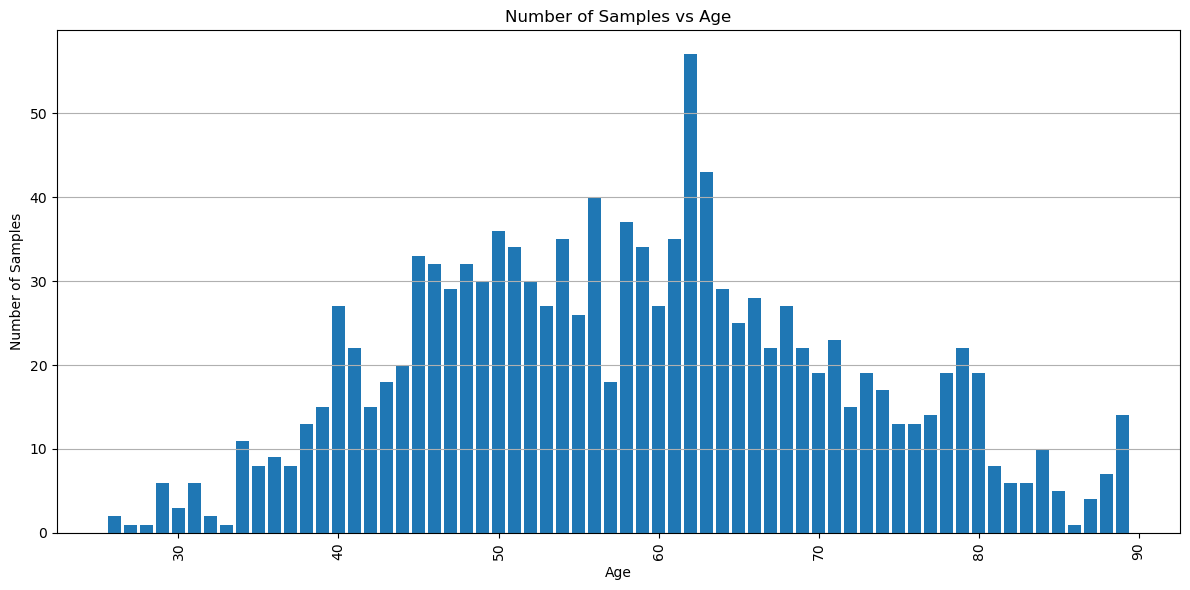

In [35]:
age_df = pd.DataFrame(age_data, columns=["Age", "Count"])

# Convert Age to numeric, setting errors='coerce' to handle '--'
age_df["Age"] = pd.to_numeric(age_df["Age"], errors='coerce')

# Drop rows with NaN Age (i.e., '--')
age_df = age_df.dropna(subset=["Age"])

age_df = age_df.sort_values("Age")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(age_df["Age"], age_df["Count"])
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.title("Number of Samples vs Age")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [46]:
adata = ad.AnnData(df_filtered.T)  # Transpose: cells x genes

In [47]:
adata

AnnData object with n_obs × n_vars = 1231 × 19529

In [48]:
for col in columns_to_group:
   adata.obs[col] = sample_clinical[col].copy()

In [49]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
adata.obs['Continuous Age'] = ages_cleaned.values

In [50]:
sc.pp.log1p(adata)

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

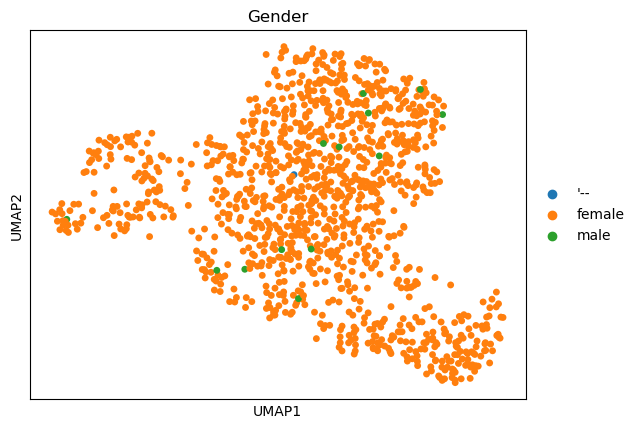

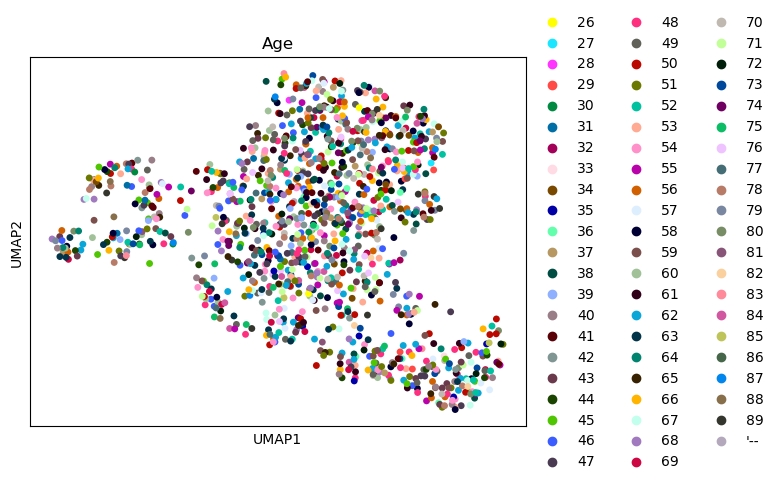

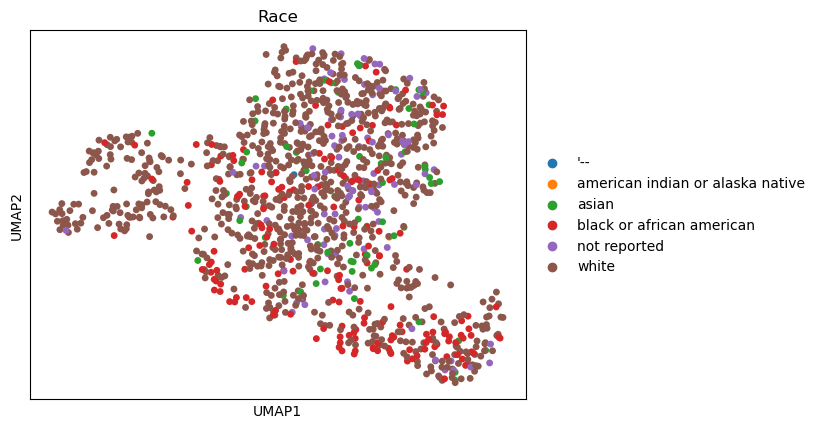

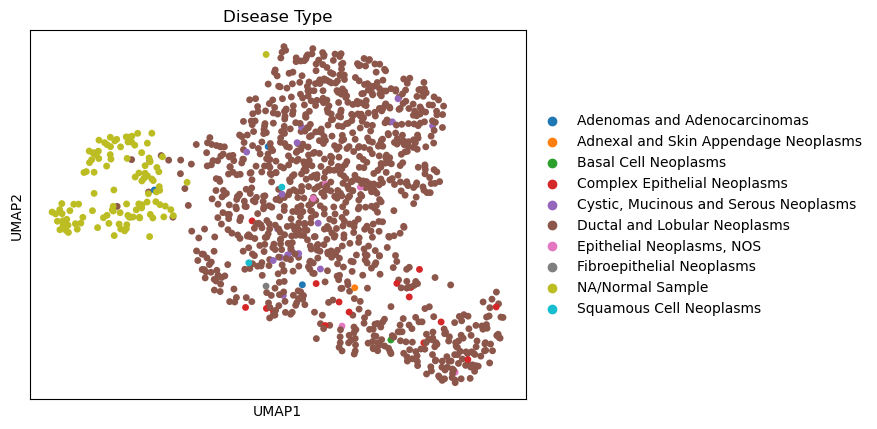

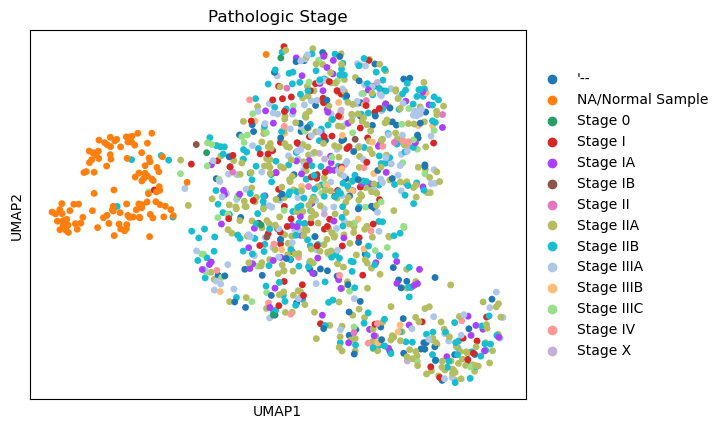

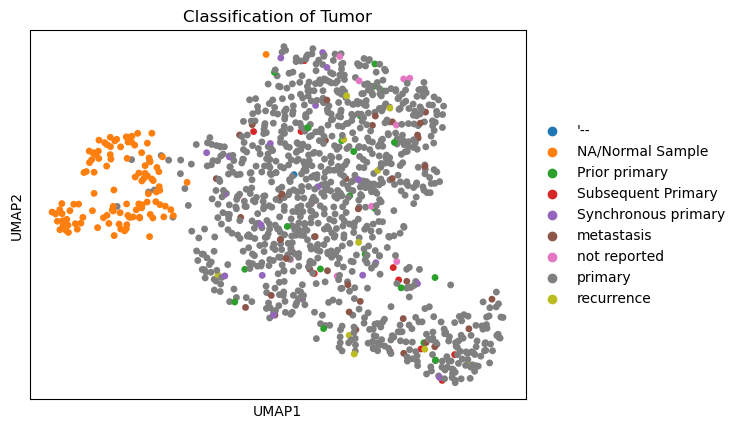

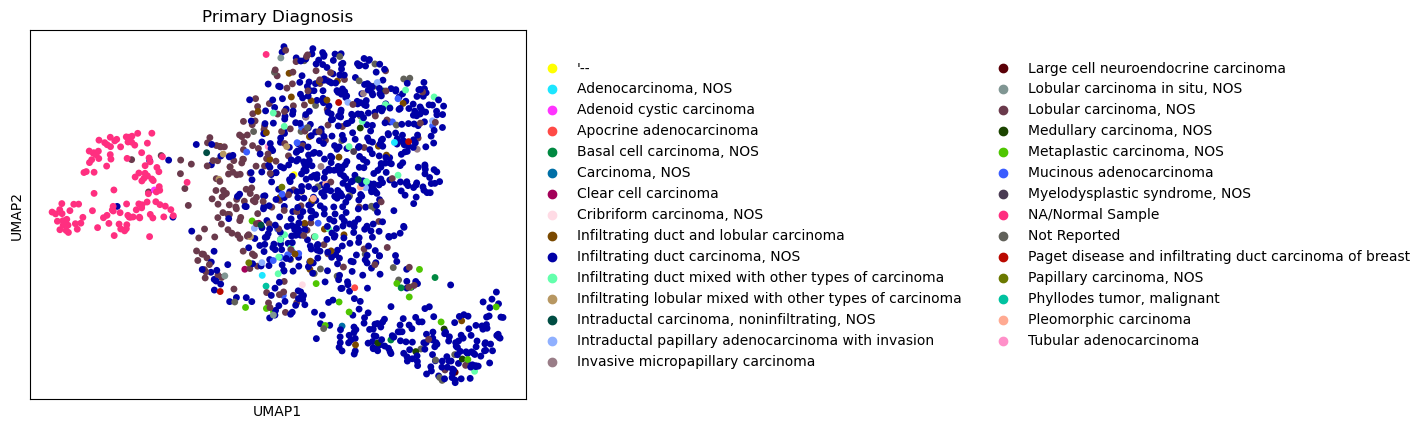

In [51]:
for key in columns_to_group_dict:
    sc.pl.umap(adata, color=columns_to_group_dict[key], title=key, save=f"_{key.replace(' ', '_')}.png")

In [58]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage X': -1,
    'Stage 0': 0.0,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage IIIA': 3.0,
    'Stage IIIB': 3.1,
    'Stage IIIC': 3.2,
    'Stage IV':   4.0
}

# Apply to adata.obs
path_key = "pathologic_stage_numeric"
adata.obs[path_key] = adata.obs["diagnoses.ajcc_pathologic_stage"].map(stage_to_num)

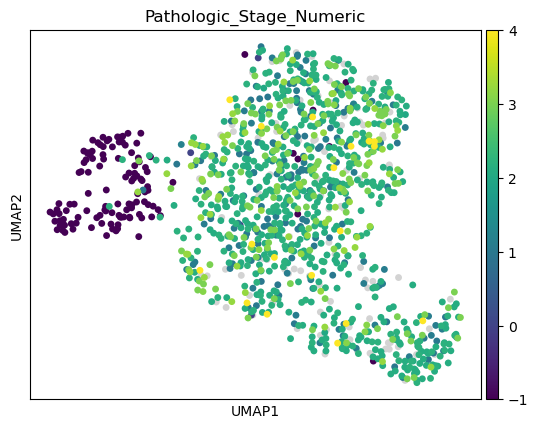

In [59]:
sc.pl.umap(adata, color=path_key, title='Pathologic_Stage_Numeric', save=f"_{path_key.replace(' ', '_')}.png")

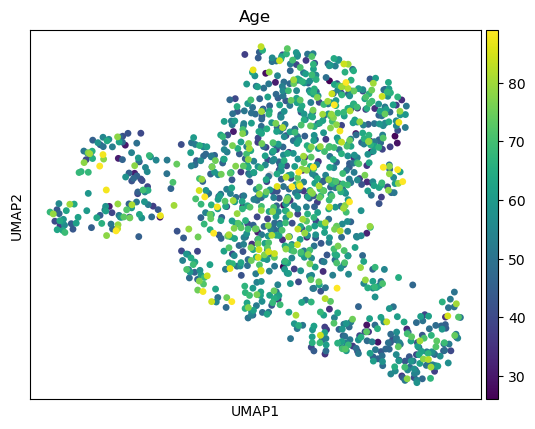

In [64]:
sc.pl.umap(adata, color='Continuous Age', title='Age', save=f"_{'age'.replace(' ', '_')}.png")

In [57]:
# Silhouette scores
umap_coords = adata.obsm['X_umap']
# Compute silhouette score
for key in columns_to_group_dict:
    labels = adata.obs[columns_to_group_dict[key]]
    score = silhouette_score(umap_coords, labels)
    print(f"Silhouette score for UMAP with {key} labels: {score:.3f}")

Silhouette score for UMAP with Gender labels: -0.306
Silhouette score for UMAP with Age labels: -0.619
Silhouette score for UMAP with Race labels: -0.416
Silhouette score for UMAP with Disease Type labels: -0.307
Silhouette score for UMAP with Pathologic Stage labels: -0.136
Silhouette score for UMAP with Classification of Tumor labels: -0.268
Silhouette score for UMAP with Primary Diagnosis labels: -0.631


In [73]:
def plot_silhouette(sil_df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=sil_df, x='label', y='silhouette', hue='label', palette='Set2', legend=False)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("Silhouette scores by condition/subtype")
    plt.ylabel("Silhouette value")
    plt.xlabel("Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

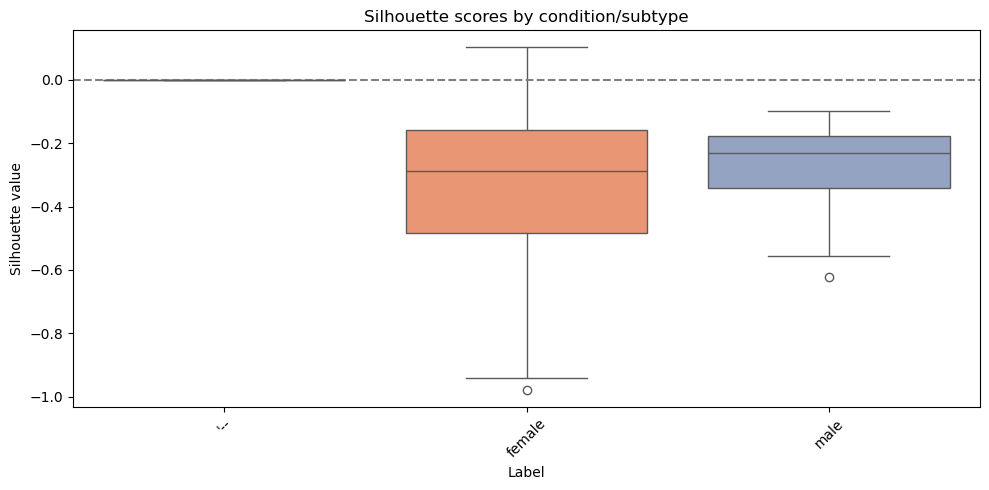

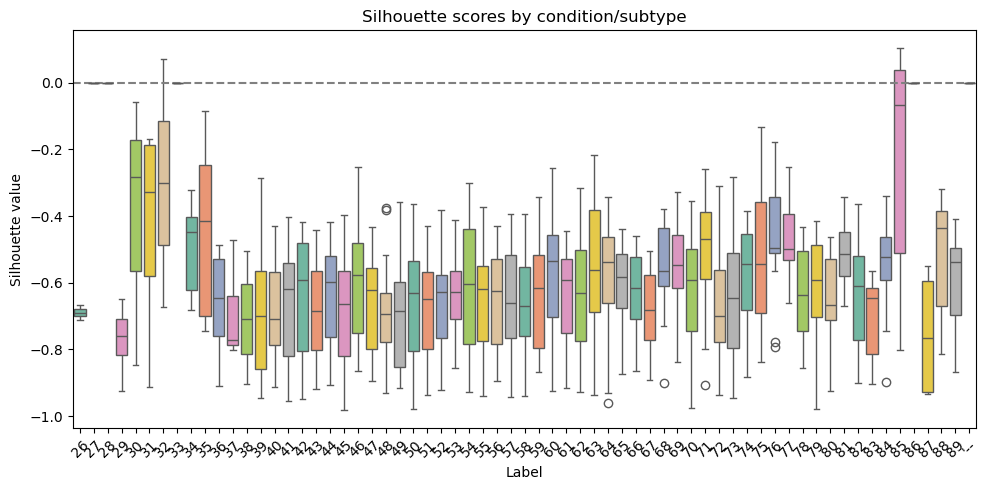

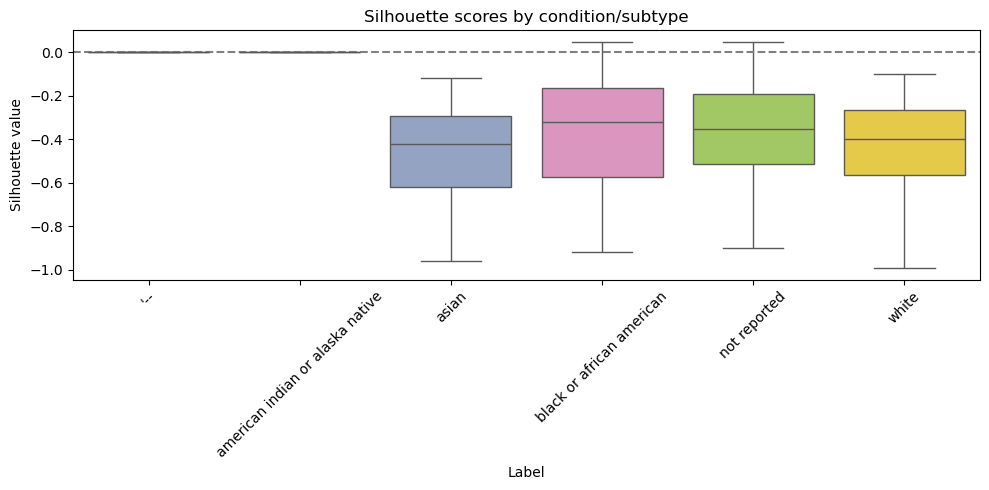

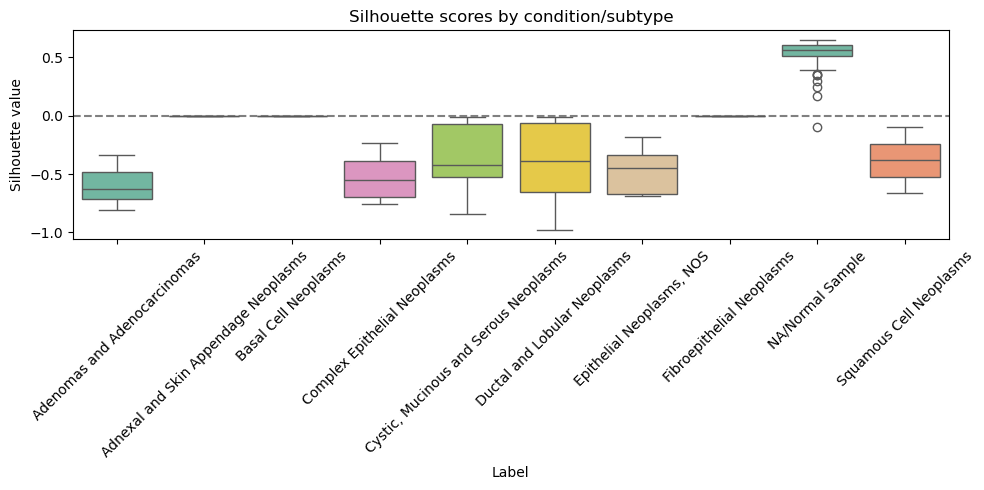

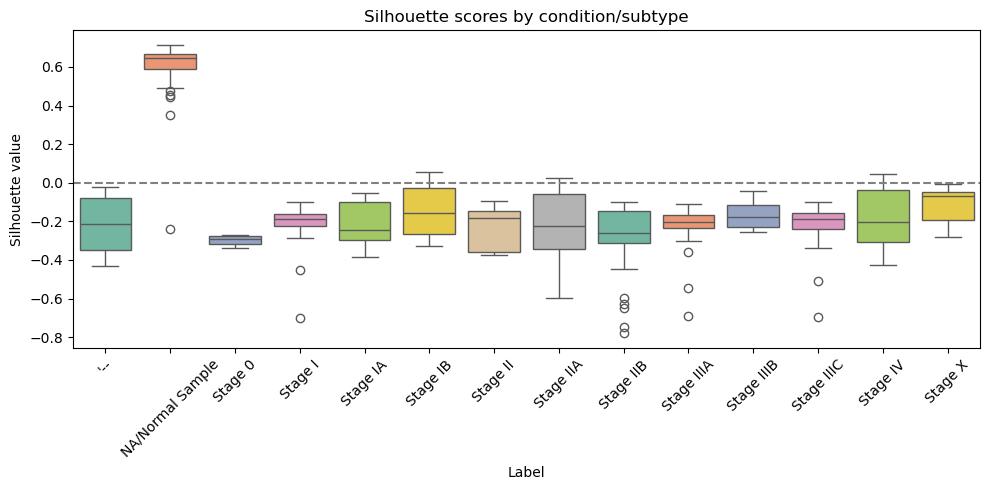

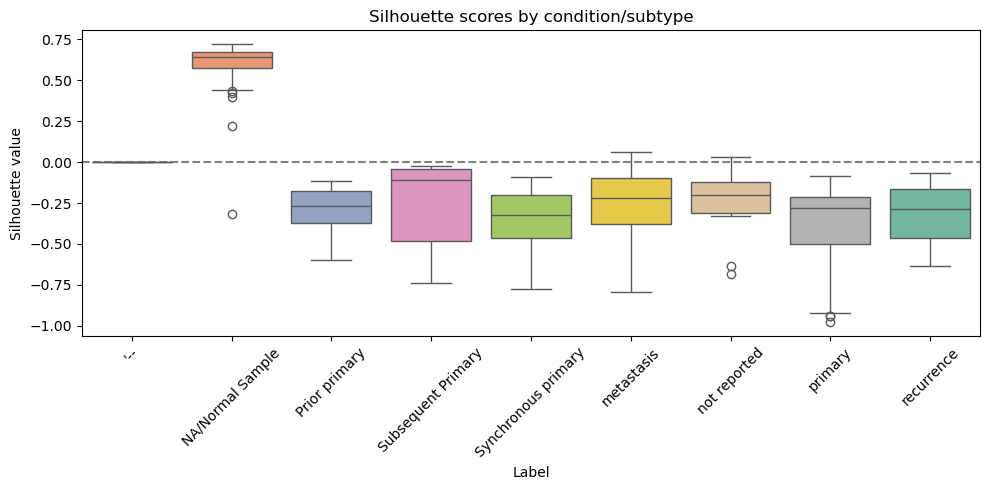

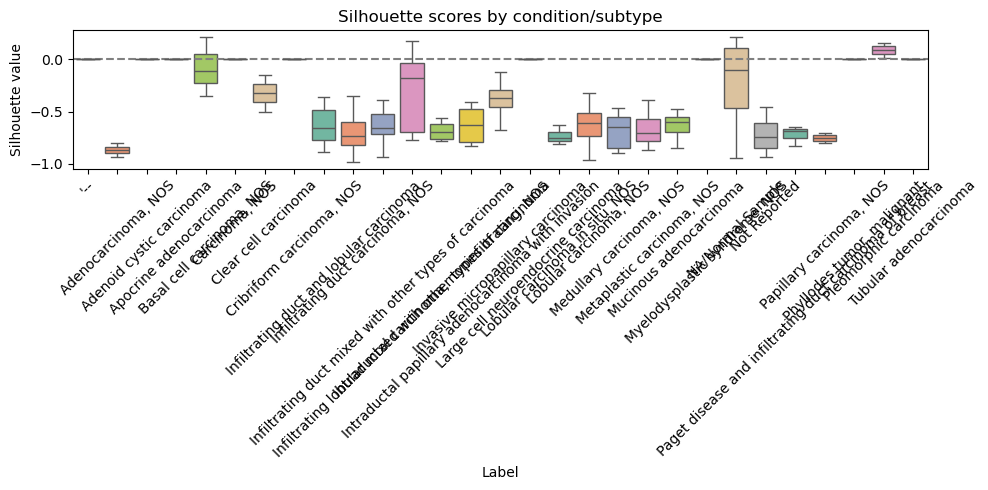

In [74]:
# Silhouette Samples
umap_coords = adata.obsm['X_umap']
# Compute silhouette score
for key in columns_to_group_dict:
    labels = adata.obs[columns_to_group_dict[key]] 
    sil_values = silhouette_samples(umap_coords, labels)
    sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
    })
    plot_silhouette(sil_df)

## PCA Plots

In [39]:
def save_pca_plot(pca_df, explained, hue, title, filename, save = True):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue, palette='tab20', s=60)
    plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    box = scatter.get_position()
    scatter.set_position([box.x0, box.y0, box.width * 0.8, box.height])  # Shrink plot
    plt.legend(
        title='Categories',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        ncol=2,  # Two-column legend
        fontsize='small',
        title_fontsize='medium'
    )
    if save: 
        plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()

## All genes

In [36]:
df_for_pca = df.T
log_norm_df_all = np.log2(df_for_pca + 1)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [37]:
pca = PCA(n_components=2)
pca_result_all = pca.fit_transform(log_norm_df_all)

pca_df_all = pd.DataFrame(data=pca_result_all, columns=['PC1', 'PC2'])
for key in columns_to_group_dict:
    pca_df_all[key] = list(sample_clinical[columns_to_group_dict[key]])


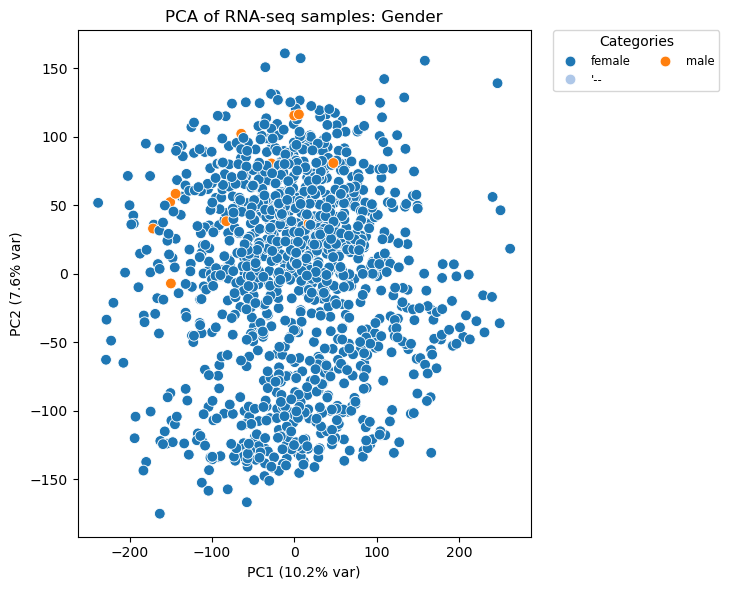

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_1093/514043987.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


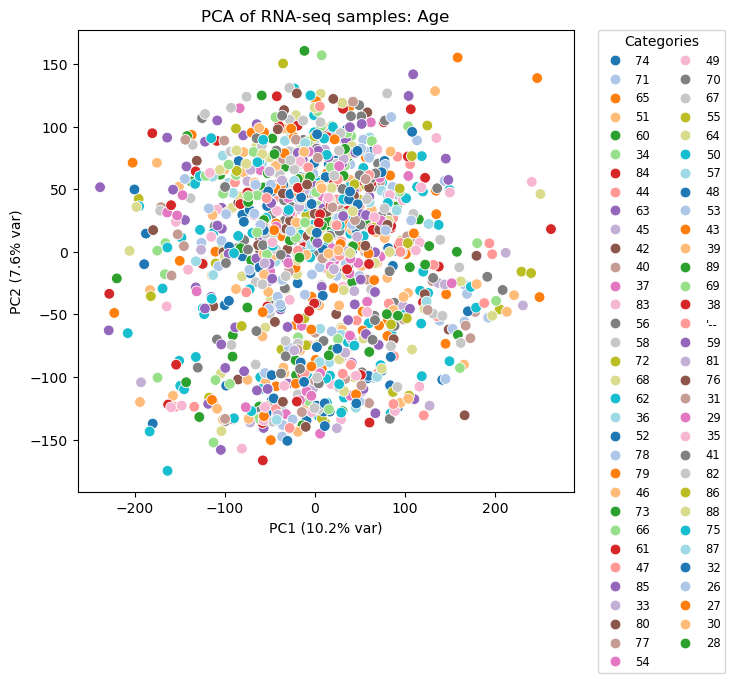

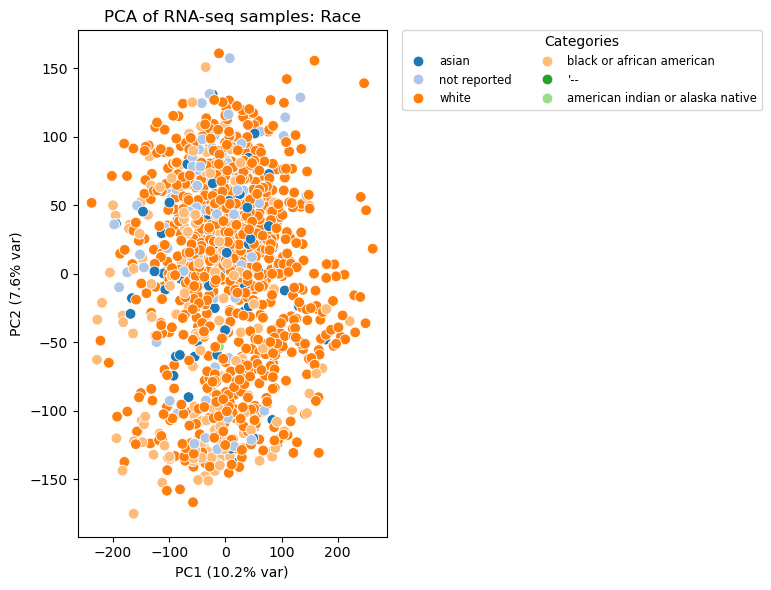

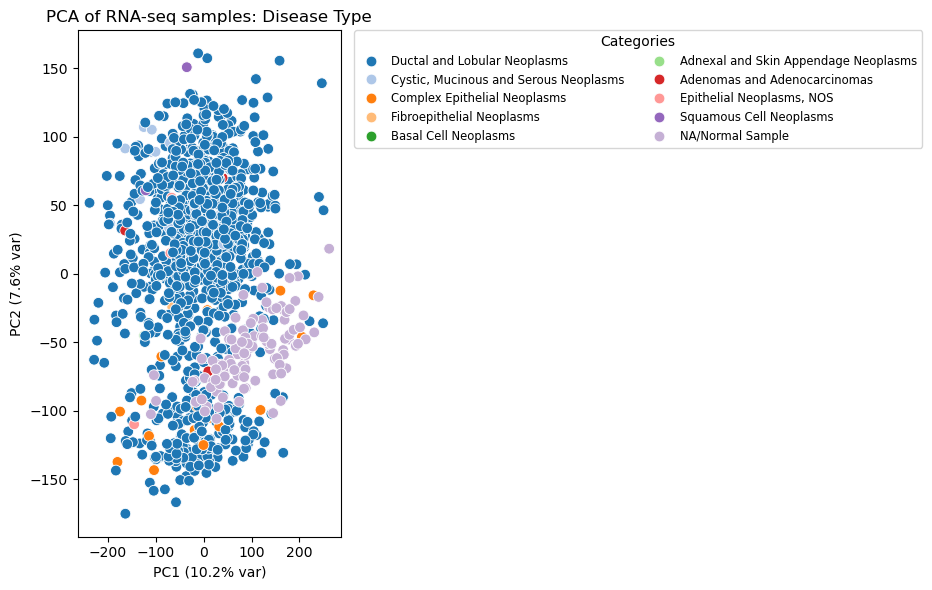

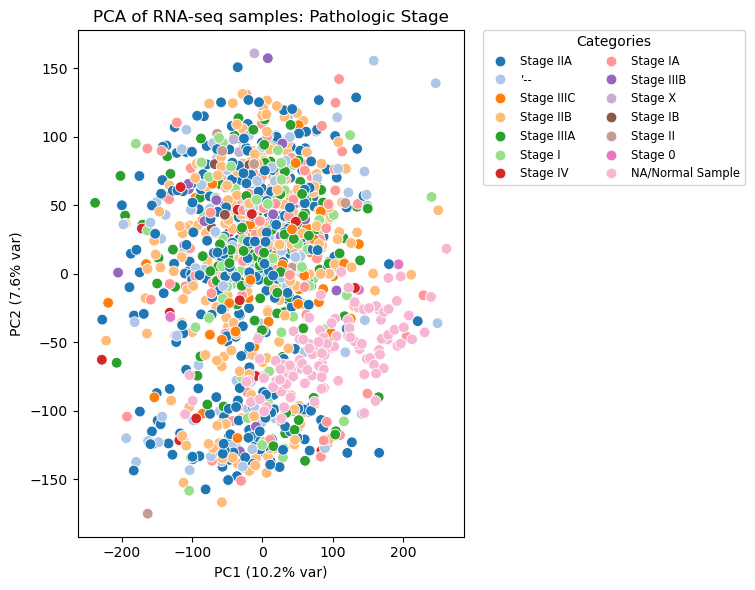

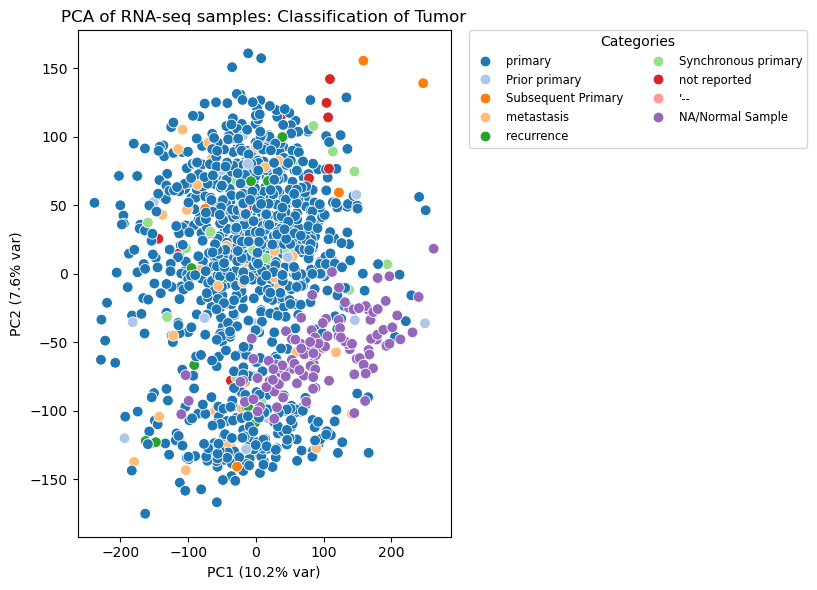

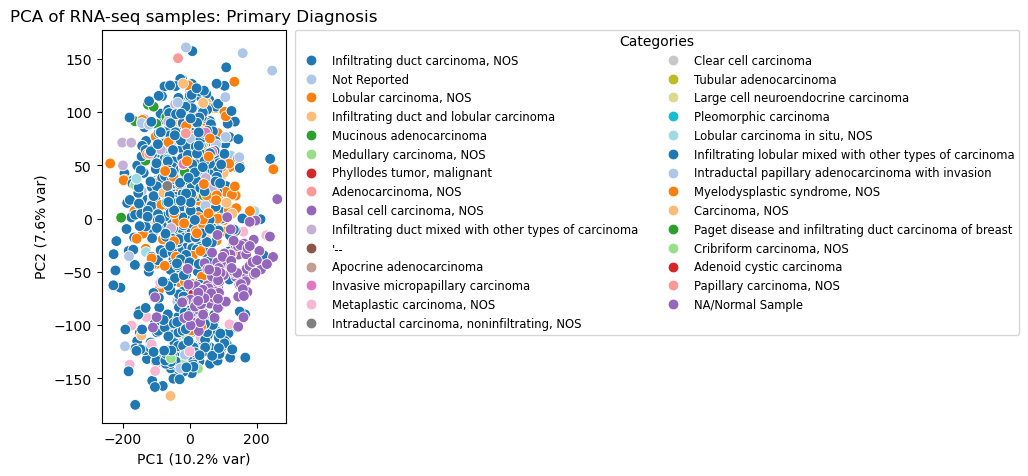

In [40]:
for key in columns_to_group_dict:
    save_pca_plot(pca_df_all, pca.explained_variance_ratio_, key,f"PCA of RNA-seq samples: {key}", f"pca_{columns_to_group_dict[key].replace(' ', '_')}.png", save = True)

In [42]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
contAgeKey = 'Continuous Age'
pca_df_all[contAgeKey] = ages_cleaned.values

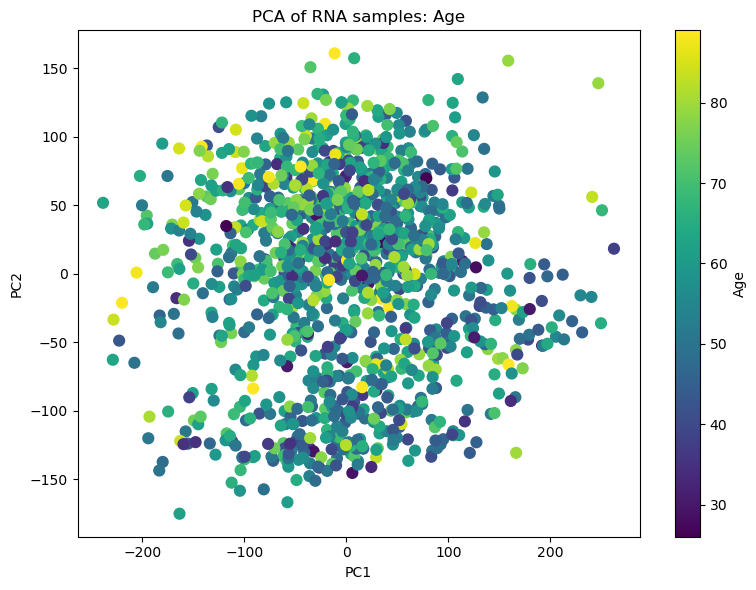

In [44]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df_all['PC1'], pca_df_all['PC2'],
    c=pca_df_all[contAgeKey],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Age")
plt.savefig("pca_age.png", dpi=300)
plt.tight_layout()
plt.show()

In [48]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage X': -1,
    'Stage 0': 0.0,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage IIIA': 3.0,
    'Stage IIIB': 3.1,
    'Stage IIIC': 3.2,
    'Stage IV':   4.0
}
cont_stage_key = "Continuous Stage"
pca_df_all[cont_stage_key] = ages_cleaned.values
# Apply to adata.obs
path_key = "pathologic_stage_numeric"
pca_df_all[path_key] = pca_df_all["Pathologic Stage"].map(stage_to_num)

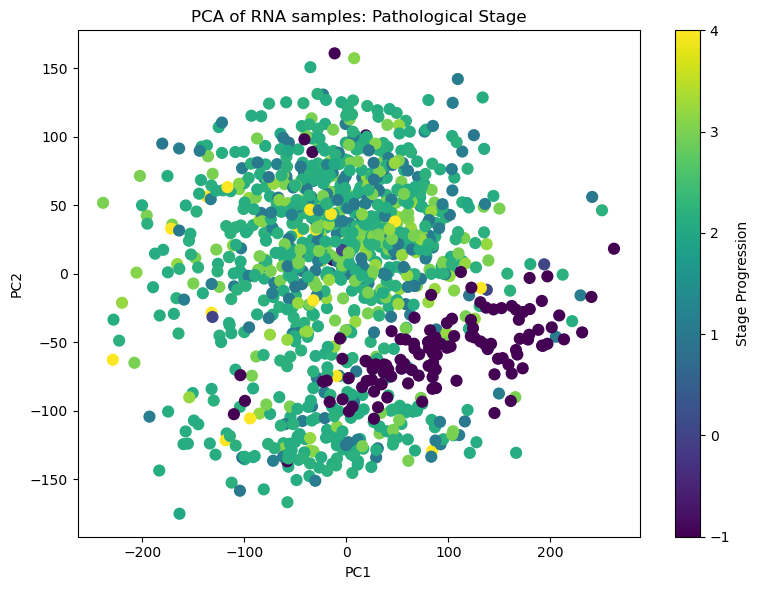

In [49]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df_all['PC1'], pca_df_all['PC2'],
    c=pca_df_all[path_key],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Stage Progression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Pathological Stage")
plt.savefig("pca_path_stage_cont.png", dpi=300)
plt.tight_layout()
plt.show()

In [50]:
X = PCA(n_components=10).fit_transform(log_norm_df_all)
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]]
    score = silhouette_score(X, labels)
    print(f"Silhouette Score of Labelling {key}: {score:.3f}")

Silhouette Score of Labelling Gender: -0.251
Silhouette Score of Labelling Age: -0.370
Silhouette Score of Labelling Race: -0.249
Silhouette Score of Labelling Disease Type: -0.135
Silhouette Score of Labelling Pathologic Stage: -0.100
Silhouette Score of Labelling Classification of Tumor: -0.192
Silhouette Score of Labelling Primary Diagnosis: -0.339


## Filtered genes

In [51]:
df_for_pca = df_filtered.T
log_norm_df = np.log2(df_for_pca + 1)
# variances = log_norm_df.var(axis=0)
# top_genes = variances.sort_values(ascending=False).head(1000).index
# log_norm_df = log_norm_df[top_genes]

In [52]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_norm_df)

# Put result in a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
for key in columns_to_group_dict:
    pca_df[key] = list(sample_clinical[columns_to_group_dict[key]])

In [53]:
pca_df

PC1        PC2  Gender Age                       Race  \
0     -76.258062  -4.257604  female  74                      asian   
1     -13.733902  64.363403  female  71               not reported   
2      22.131983  67.412236  female  65                      white   
3     -19.743248 -68.782632  female  51                      white   
4      32.739931  29.441348  female  60                      white   
...          ...        ...     ...  ..                        ...   
1226  136.518845 -46.696220  female  58  black or african american   
1227   47.307931 -60.682750  female  83                      white   
1228   73.969113 -52.529844  female  66                      white   
1229   36.732340 -61.323381  female  48                      white   
1230  183.254067 -16.187814  female  45                      white   

                      Disease Type  Pathologic Stage Classification of Tumor  \
0     Ductal and Lobular Neoplasms         Stage IIA                 primary   
1     Ductal and Lobular Neoplasms               '--           Prior primary   
2     Ductal and Lobular Neoplasms         Stage IIA                 primary   
3     Ductal and Lobular Neoplasms               '--      Subsequent Primary   
4     Ductal and Lobular Neoplasms        Stage IIIC                 primary   
...                            ...               ...                     ...   
1226              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1227              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1228              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1229              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1230              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   

                     Primary Diagnosis  
0     Infiltrating duct carcinoma, NOS  
1                         Not Reported  
2               Lobular carcinoma, NOS  
3                         Not Reported  
4     Infiltrating duct carcinoma, NOS  
...                                ...  
1226                  NA/Normal Sample  
1227                  NA/Normal Sample  
1228                  NA/Normal Sample  
1229                  NA/Normal Sample  
1230                  NA/Normal Sample  

[1231 rows x 9 columns]

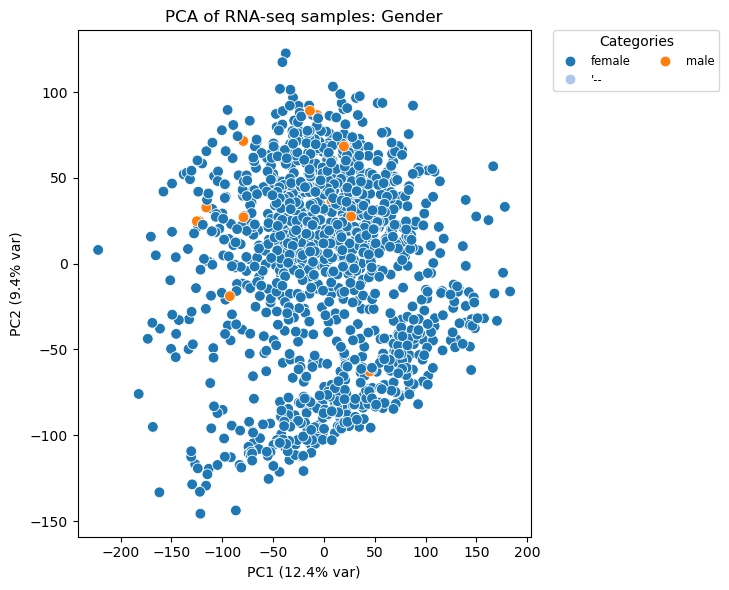

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_1093/514043987.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


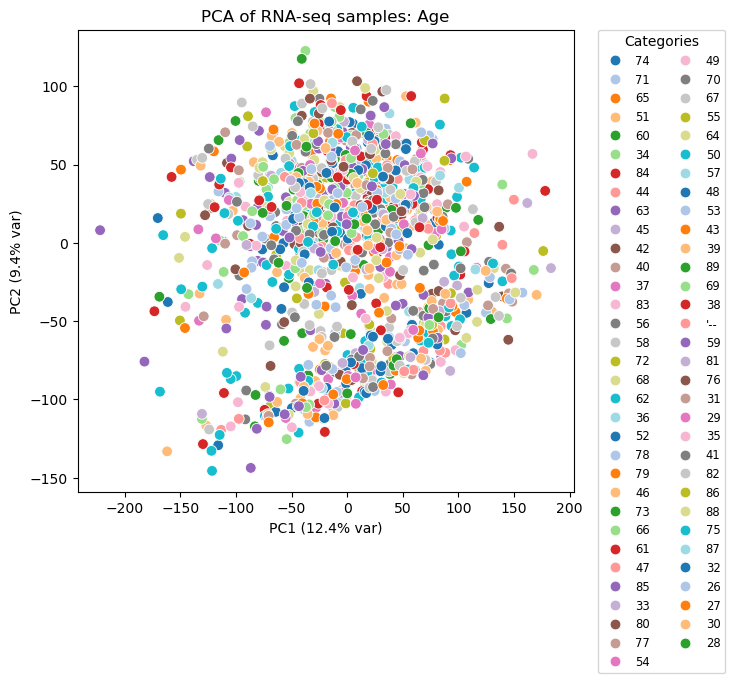

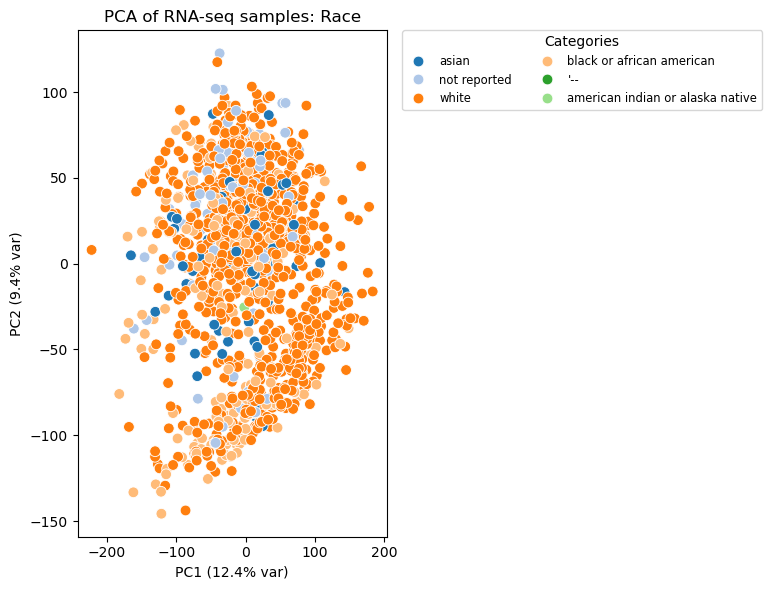

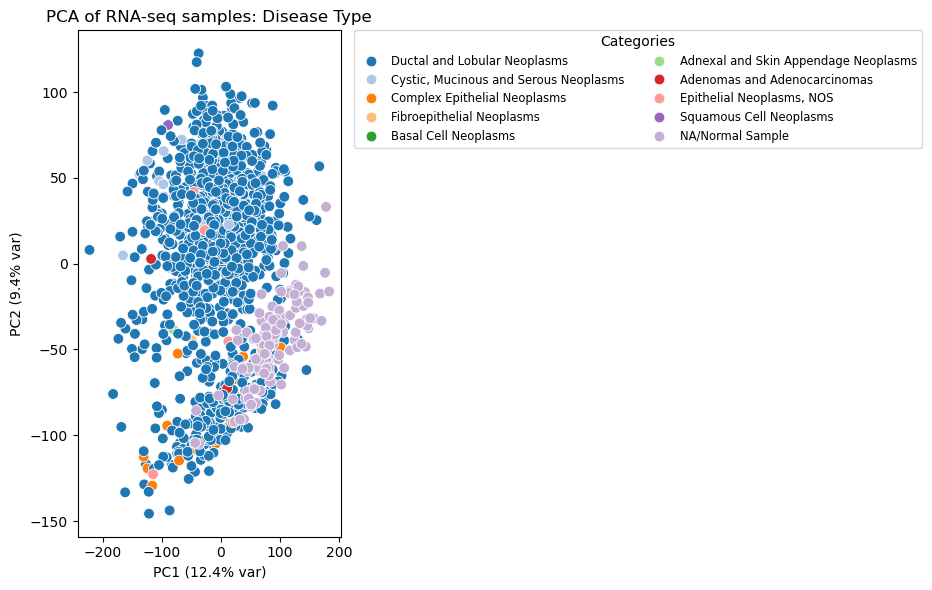

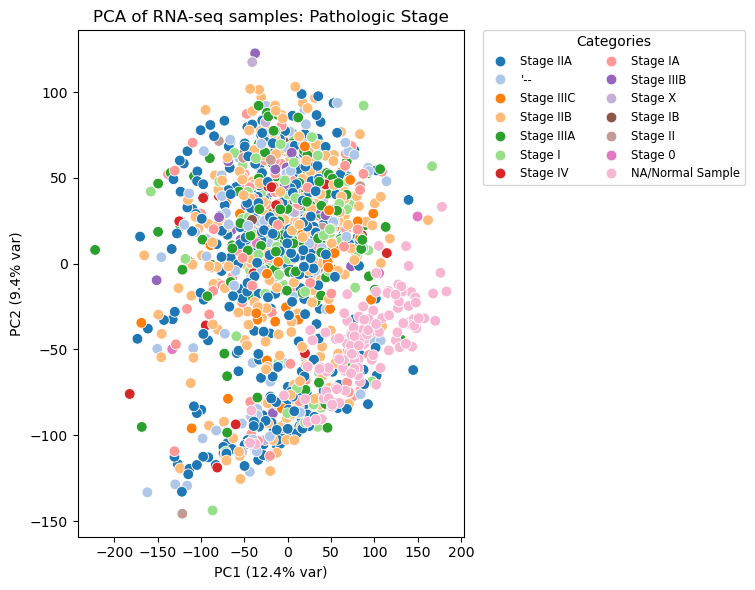

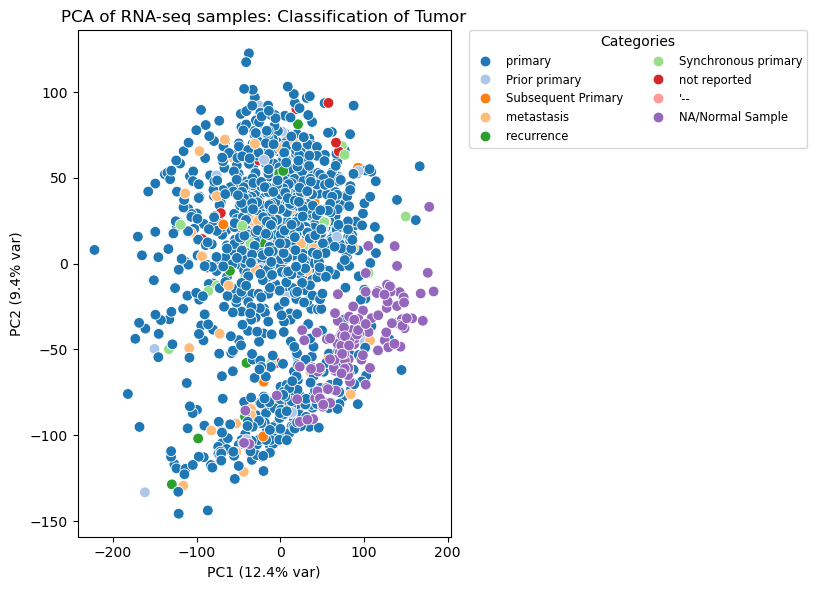

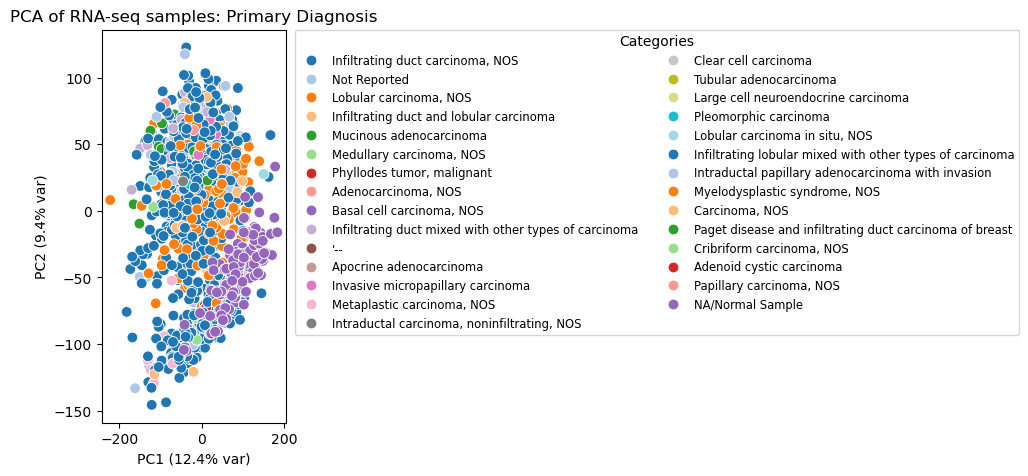

In [54]:
for key in columns_to_group_dict:
    save_pca_plot(pca_df, pca.explained_variance_ratio_, key,f"PCA of RNA-seq samples: {key}", f"pca_{columns_to_group_dict[key].replace(' ', '_')}.png", save = False)

In [55]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
contAgeKey = 'Continuous Age'
pca_df[contAgeKey] = ages_cleaned.values

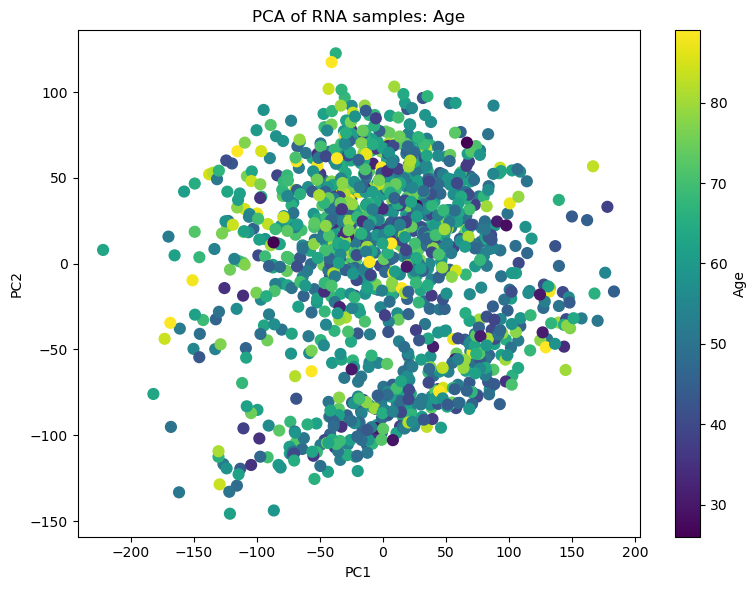

In [56]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df[contAgeKey],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Age")
plt.savefig("pca_age.png", dpi=300)
plt.tight_layout()
plt.show()

In [57]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage X': -1,
    'Stage 0': 0.0,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage IIIA': 3.0,
    'Stage IIIB': 3.1,
    'Stage IIIC': 3.2,
    'Stage IV':   4.0
}
cont_stage_key = "Continuous Stage"
pca_df[cont_stage_key] = ages_cleaned.values
# Apply to adata.obs
path_key = "pathologic_stage_numeric"
pca_df[path_key] = pca_df["Pathologic Stage"].map(stage_to_num)

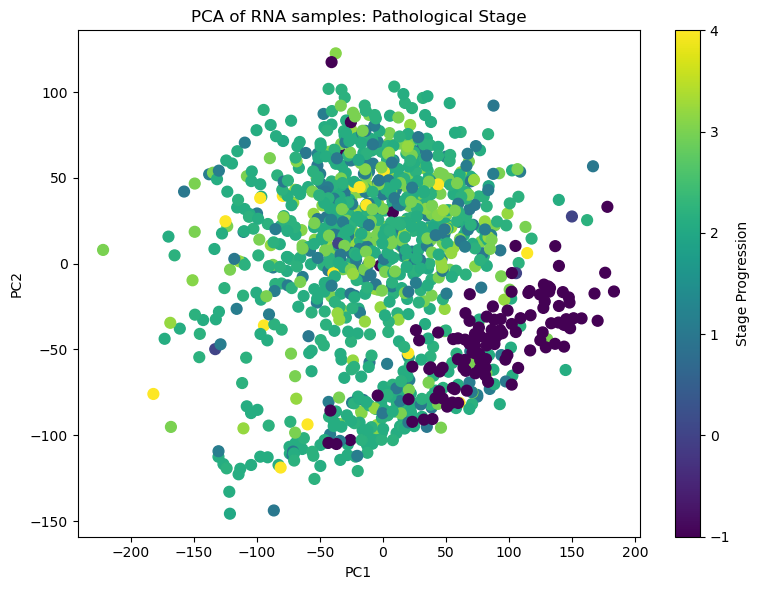

In [58]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df[path_key],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Stage Progression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Pathological Stage")
plt.savefig("pca_path_stage_cont.png", dpi=300)
plt.tight_layout()
plt.show()

### Silhouette Scores

In [59]:
X = PCA(n_components=10).fit_transform(log_norm_df)
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]]
    score = silhouette_score(X, labels)
    print(f"Silhouette Score of Labelling {key}: {score:.3f}")

Silhouette Score of Labelling Gender: -0.247
Silhouette Score of Labelling Age: -0.363
Silhouette Score of Labelling Race: -0.247
Silhouette Score of Labelling Disease Type: -0.121
Silhouette Score of Labelling Pathologic Stage: -0.084
Silhouette Score of Labelling Classification of Tumor: -0.187
Silhouette Score of Labelling Primary Diagnosis: -0.331


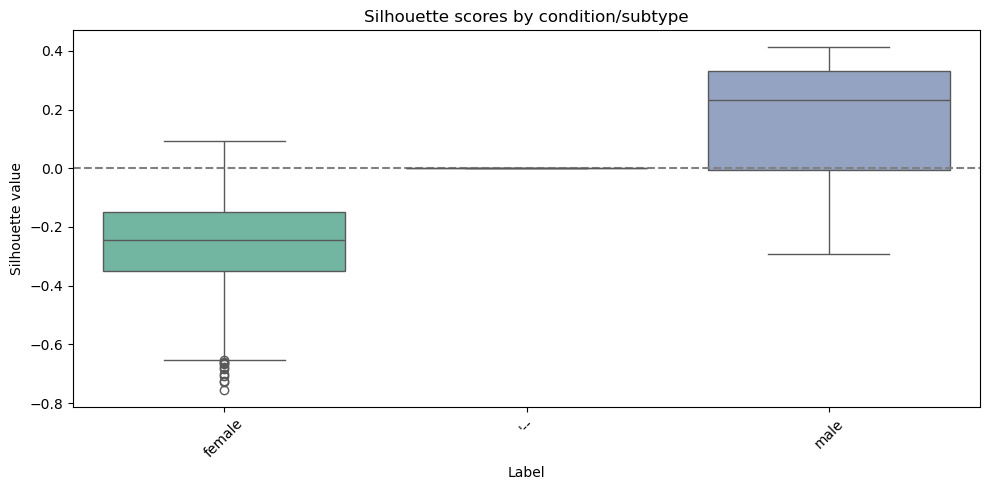

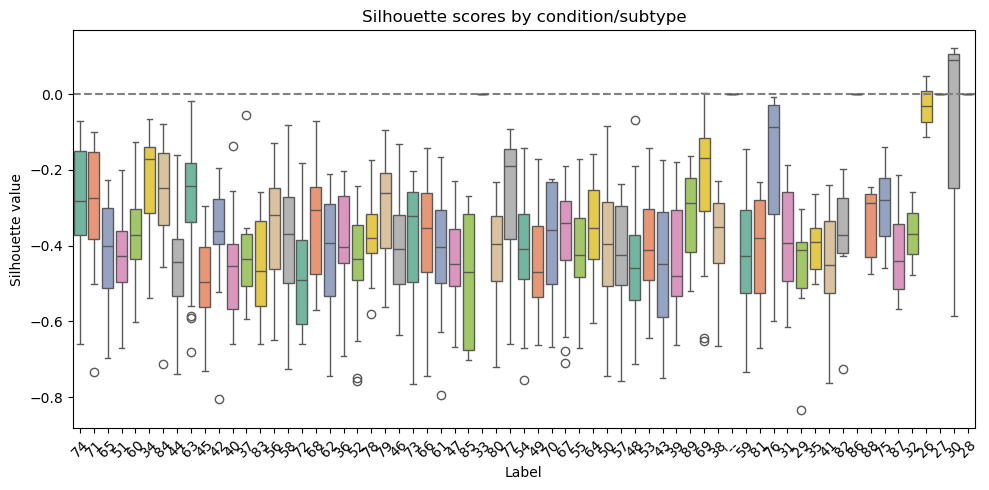

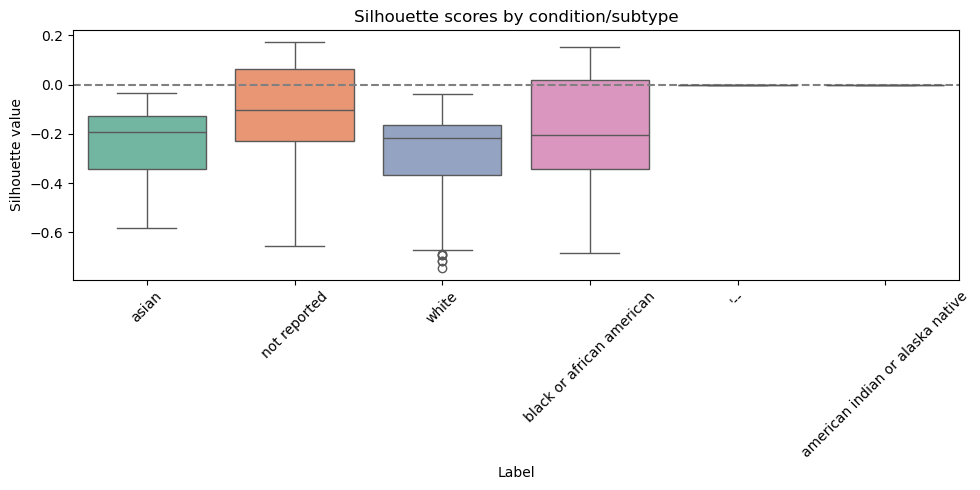

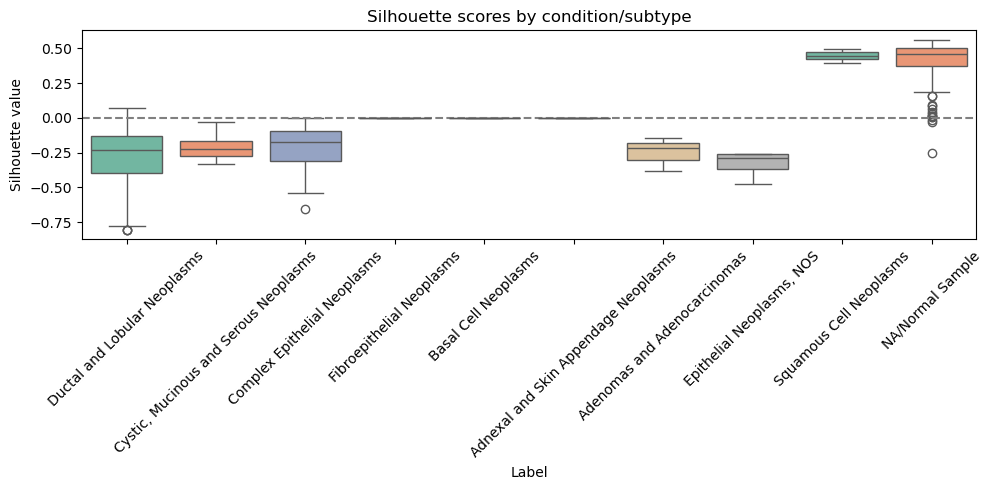

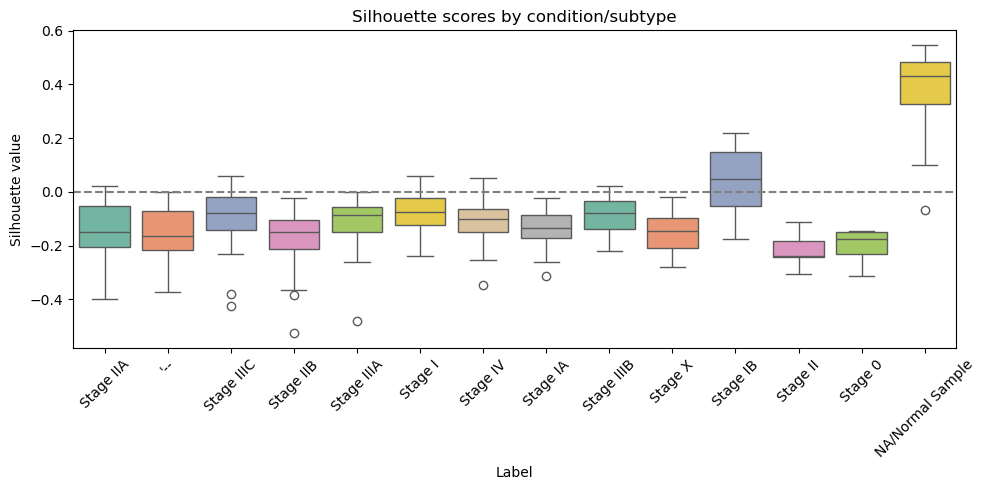

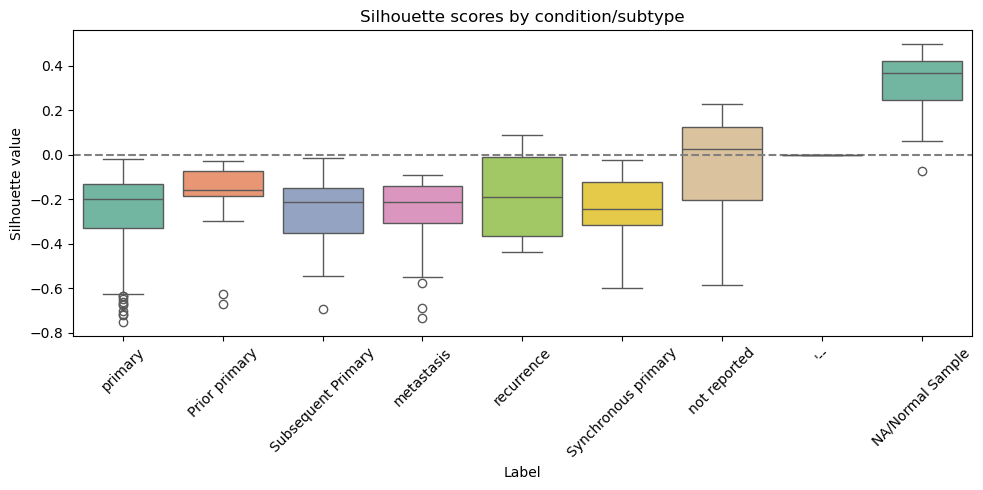

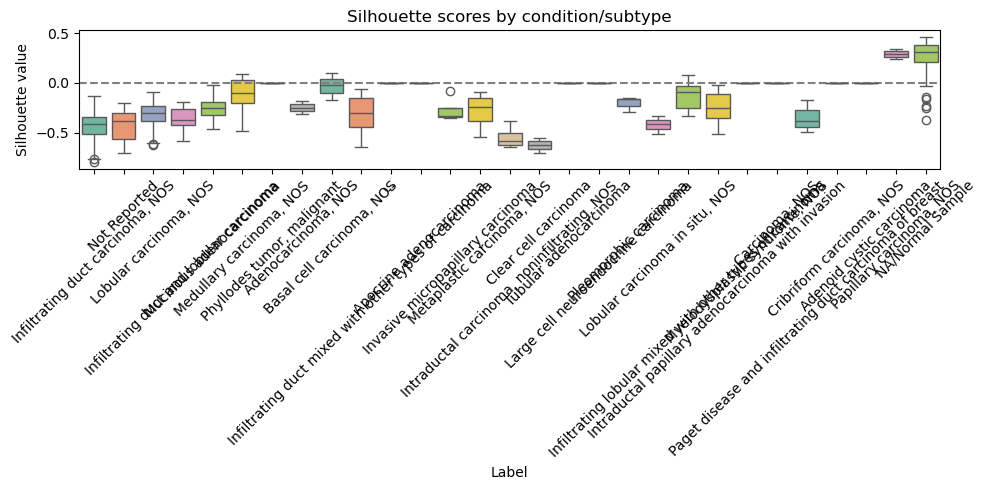

In [96]:
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]] 
    sil_values = silhouette_samples(X, labels)
    sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
    })
    plot_silhouette(sil_df)

In [60]:
X = PCA(n_components=3).fit_transform(log_norm_df)
pcs = pd.DataFrame(X, columns=[f'PC{i+1}' for i in range(3)], index=df_filtered.columns)
metadata = sample_clinical[['demographic.age_at_index', 'demographic.gender', 'demographic.race']].copy()
# Ensure correct dtypes
metadata['demographic.gender'] = metadata['demographic.gender'].astype('category')
metadata['demographic.race'] = metadata['demographic.race'].astype('category')

In [61]:
metadata['Gender'] = metadata['demographic.gender']
metadata['Race']= metadata['demographic.race']
metadata['Age']= metadata['demographic.age_at_index']
df_var = pd.concat([pcs, metadata], axis=1)

In [64]:
results = []
for pc in pcs.columns:
    formula = f"{pc} ~ Age + Gender + Race"
    model = ols(formula, data=df_var).fit()
    r2 = model.rsquared
    results.append({'PC': pc, 'Variance_Explained (%)': round(r2 * 100, 2)})

results_df = pd.DataFrame(results)
print(results_df)

    PC  Variance_Explained (%)
0  PC1                   13.93
1  PC2                   10.83
2  PC3                   10.89


In [65]:
all_results = []

for pc in pcs.columns:
    formula = f"{pc} ~ Age + Gender + Race"
    model = ols(formula, data=df_var).fit()
    anova_results = anova_lm(model)

    ss_total = anova_results['sum_sq'].sum()
    for idx, row in anova_results.iterrows():
        if idx != 'Residual':
            var_exp = row['sum_sq'] / ss_total * 100
            all_results.append({
                'PC': pc,
                'Variable': idx,
                'Variance_Explained (%)': round(var_exp, 2)
            })

results_df = pd.DataFrame(all_results)
print(results_df)

    PC Variable  Variance_Explained (%)
0  PC1      Age                    8.60
1  PC1   Gender                    0.55
2  PC1     Race                    4.83
3  PC2      Age                    5.45
4  PC2   Gender                    0.90
5  PC2     Race                    4.86
6  PC3      Age                    6.93
7  PC3   Gender                    0.03
8  PC3     Race                    3.97


## Grouping primary diagnosis


In [118]:
# Define mapping
group_map = {
    'Infiltrating duct carcinoma, NOS': 'Infiltrating Ductal Carcinoma',
    'Infiltrating duct mixed with other types of carcinoma': 'Infiltrating Ductal Carcinoma',
    'Paget disease and infiltrating duct carcinoma of breast': 'Infiltrating Ductal Carcinoma',
    'Infiltrating duct and lobular carcinoma': 'Infiltrating Duct and Lobular Carcinoma',

    'Lobular carcinoma, NOS': 'Infiltrating Lobular Carcinoma',
    'Lobular carcinoma in situ, NOS': 'Infiltrating Lobular Carcinoma',
    'Infiltrating lobular mixed with other types of carcinoma': 'Infiltrating Lobular Carcinoma',

    'Mucinous adenocarcinoma': 'Other Adenocarcinoma',
    'Apocrine adenocarcinoma': 'Other Adenocarcinoma',
    'Adenocarcinoma, NOS': 'Other Adenocarcinoma',
    'Tubular adenocarcinoma': 'Other Adenocarcinoma',

    'Metaplastic carcinoma, NOS': 'Other Carcinoma',
    'Cribriform carcinoma, NOS': 'Other Carcinoma',
    'Clear cell carcinoma': 'Other Carcinoma',
    'Medullary carcinoma, NOS': 'Other Carcinoma',
    'Large cell neuroendocrine carcinoma': 'Other Carcinoma',
    'Pleomorphic carcinoma': 'Other Carcinoma',
    'Basal cell carcinoma, NOS': 'Other Carcinoma',
    'Adenoid cystic carcinoma': 'Other Carcinoma',
    'Papillary carcinoma, NOS': 'Other Carcinoma',
    'Carcinoma, NOS': 'Other Carcinoma',

    'Phyllodes tumor, malignant': 'Misc',
    'Myelodysplastic syndrome, NOS': 'Misc',

    'NA/Normal Sample': 'NA/Normal Sample',
    'Not Reported': 'Not Reported'
}
# Add to adata and pca
grouped_diagnosis_key = 'diagnosis_grouped'
adata.obs[grouped_diagnosis_key] = adata.obs['diagnoses.primary_diagnosis'].map(group_map).fillna('Not Reported')
pca_df[grouped_diagnosis_key] = pca_df['Primary Diagnosis'].map(group_map).fillna('Not Reported')

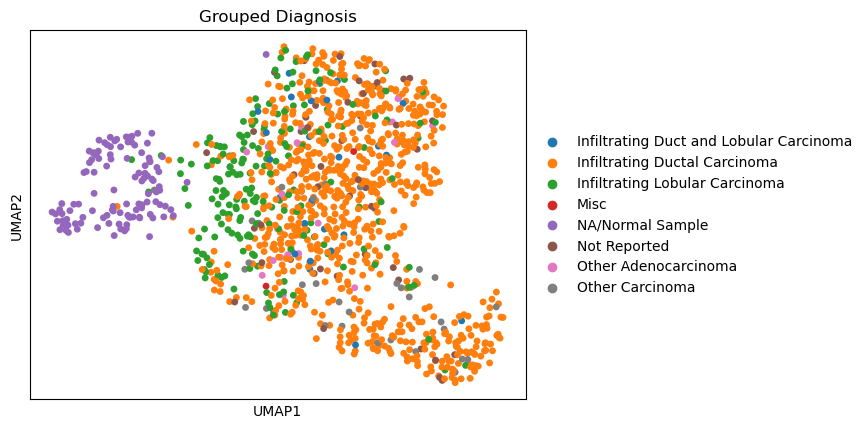

In [119]:
sc.pl.umap(adata, color=grouped_diagnosis_key, title='Grouped Diagnosis', save=f"_{grouped_diagnosis_key.replace(' ', '_')}.png")

In [120]:
labels = adata.obs[grouped_diagnosis_key]
score = silhouette_score(umap_coords, labels)
print(f"Silhouette score for UMAP with Grouped Diagnosis labels: {score:.3f}")

Silhouette score for UMAP with Grouped Diagnosis labels: -0.132


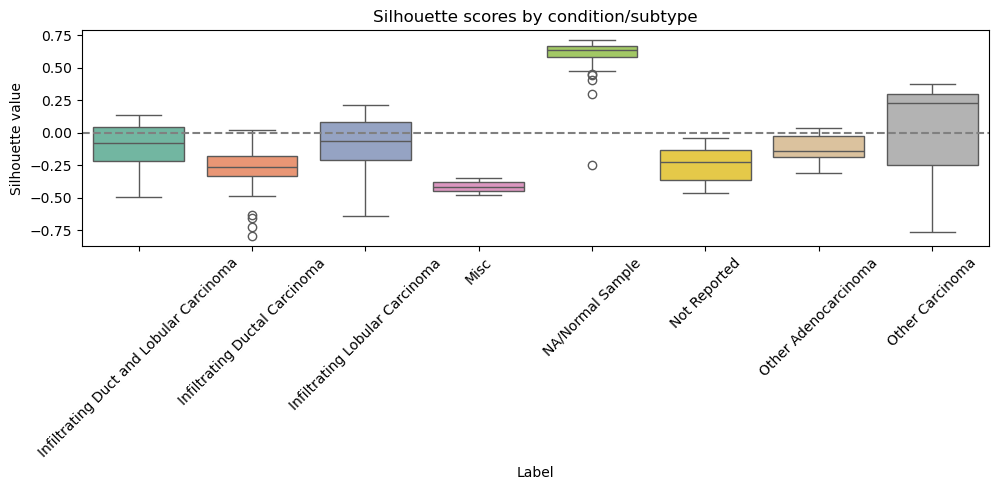

In [121]:
sil_values = silhouette_samples(umap_coords, labels)
sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
})
plot_silhouette(sil_df)

## PCA on grouped data

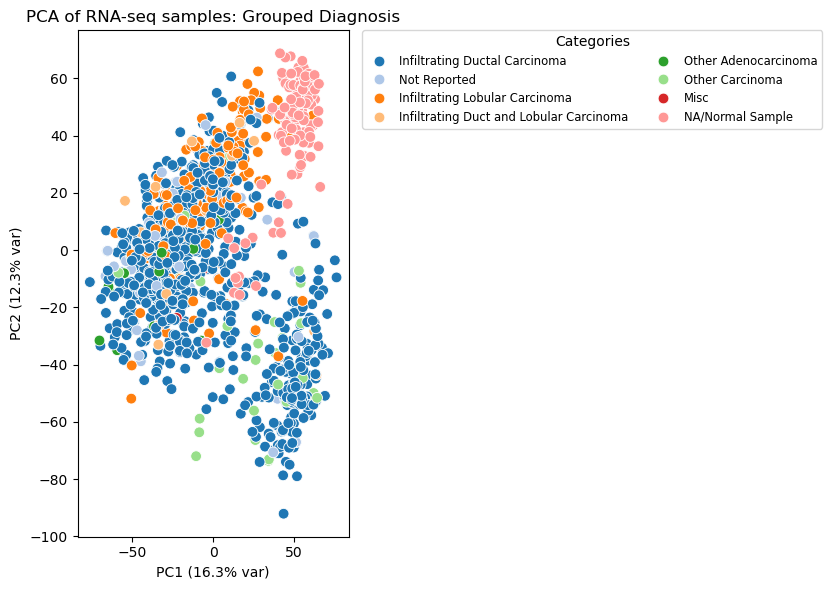

In [148]:
save_pca_plot(pca_df, pca.explained_variance_ratio_, grouped_diagnosis_key,f"PCA of RNA-seq samples: {"Grouped Diagnosis"}", f"pca_{grouped_diagnosis_key.replace(' ', '_')}.png", save = True)

In [122]:
labels = pca_df[grouped_diagnosis_key]
score = silhouette_score(X, labels)
print(f"Silhouette Score of Labelling {grouped_diagnosis_key}: {score:.3f}")

Silhouette Score of Labelling diagnosis_grouped: -0.092


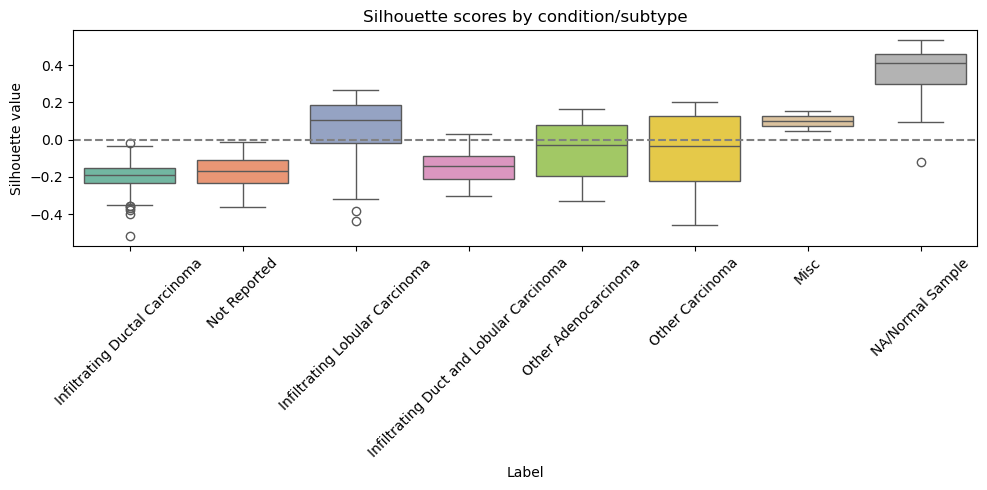

In [123]:
labels = pca_df[grouped_diagnosis_key] 
sil_values = silhouette_samples(X, labels)
sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
})
plot_silhouette(sil_df)

## Subset to DESeq2 Categories

In [124]:
pca_df[grouped_diagnosis_key]

0        Infiltrating Ductal Carcinoma
1                         Not Reported
2       Infiltrating Lobular Carcinoma
3                         Not Reported
4        Infiltrating Ductal Carcinoma
                     ...              
1226                  NA/Normal Sample
1227                  NA/Normal Sample
1228                  NA/Normal Sample
1229                  NA/Normal Sample
1230                  NA/Normal Sample
Name: diagnosis_grouped, Length: 1231, dtype: object

In [125]:
sample_clinical[grouped_diagnosis_key] = list(pca_df[grouped_diagnosis_key])

In [126]:
sample_clinical[grouped_diagnosis_key]

2c3000b7-4db9-4f00-a82a-ca6802806631     Infiltrating Ductal Carcinoma
519b92e0-0dbc-471c-988f-48ce9dc95be3                      Not Reported
f2bf29d2-4c33-4810-90e8-88f37ea47bc8    Infiltrating Lobular Carcinoma
59858555-bc6a-4286-8280-0f8341123cac                      Not Reported
de6f1503-33d7-4f86-b835-bdffba7ea4e3     Infiltrating Ductal Carcinoma
                                                     ...              
5e789924-9d98-4765-a348-90a27349d906                  NA/Normal Sample
8a84b9a5-d453-416b-b481-f15402c2eb54                  NA/Normal Sample
ccb87d7a-2729-4017-bc17-10e5a67bd5cc                  NA/Normal Sample
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf                  NA/Normal Sample
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac                  NA/Normal Sample
Name: diagnosis_grouped, Length: 1231, dtype: object

In [127]:
metadata_file = f"DESeq2Local/DESeq2Input/breast_{grouped_diagnosis_key}_Metadata.csv"
condition_counts = sample_clinical[grouped_diagnosis_key].copy()
breast_granular_metadata_df = pd.DataFrame(list(condition_counts.items()), columns= ['sample_id', 'condition'])
breast_granular_metadata_df.index = breast_granular_metadata_df['sample_id']
breast_granular_metadata_df = breast_granular_metadata_df.drop('sample_id', axis =1)
breast_granular_metadata_df['condition'] = (
     breast_granular_metadata_df['condition']
    .str.lower()                        # lowercase everything
    .str.replace(r"[ /]", "_", regex=True)  # replace spaces and slashes with underscores
    .str.replace(r"[^a-z0-9_]", "", regex=True)  # remove any other unwanted characters
)
breast_granular_metadata_df

condition
sample_id                                                           
2c3000b7-4db9-4f00-a82a-ca6802806631   infiltrating_ductal_carcinoma
519b92e0-0dbc-471c-988f-48ce9dc95be3                    not_reported
f2bf29d2-4c33-4810-90e8-88f37ea47bc8  infiltrating_lobular_carcinoma
59858555-bc6a-4286-8280-0f8341123cac                    not_reported
de6f1503-33d7-4f86-b835-bdffba7ea4e3   infiltrating_ductal_carcinoma
...                                                              ...
5e789924-9d98-4765-a348-90a27349d906                na_normal_sample
8a84b9a5-d453-416b-b481-f15402c2eb54                na_normal_sample
ccb87d7a-2729-4017-bc17-10e5a67bd5cc                na_normal_sample
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf                na_normal_sample
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac                na_normal_sample

[1231 rows x 1 columns]

In [128]:
breast_granular_metadata_df.to_csv(metadata_file)

In [131]:
print(grouped_diagnosis_key, len(sample_clinical[sample_clinical[column]==grouped_diagnosis_key]))

diagnosis_grouped 0


In [132]:
sample_clinical[column]==grouped_diagnosis_key

2c3000b7-4db9-4f00-a82a-ca6802806631    False
519b92e0-0dbc-471c-988f-48ce9dc95be3    False
f2bf29d2-4c33-4810-90e8-88f37ea47bc8    False
59858555-bc6a-4286-8280-0f8341123cac    False
de6f1503-33d7-4f86-b835-bdffba7ea4e3    False
                                        ...  
5e789924-9d98-4765-a348-90a27349d906    False
8a84b9a5-d453-416b-b481-f15402c2eb54    False
ccb87d7a-2729-4017-bc17-10e5a67bd5cc    False
040d00da-2bc9-49d4-bf6c-b4515b6a2bbf    False
8ebe0bf6-11fa-418d-918c-5c73f0e7e9ac    False
Name: diagnoses.primary_diagnosis, Length: 1231, dtype: bool

In [133]:
grouped_diagnosis_key

'diagnosis_grouped'

In [134]:
categories = sample_clinical[grouped_diagnosis_key].unique()
print("Considered Column", column)
for cat in categories:
    print(cat, len(sample_clinical[sample_clinical[grouped_diagnosis_key]==cat]))

Considered Column diagnoses.primary_diagnosis
Infiltrating Ductal Carcinoma 789
Not Reported 50
Infiltrating Lobular Carcinoma 196
Infiltrating Duct and Lobular Carcinoma 28
Other Adenocarcinoma 19
Other Carcinoma 34
Misc 2
NA/Normal Sample 113
